# Data Quality Notebook – London Cycle Hire (2022)

This notebook focuses on assessing and improving the **data quality** of the London Cycle Hire dataset for the calendar year **2022**.

We will be working with the **saved Parquet snippet** of the data, ensuring the dataset does not need to be loaded or need of queries of the dataset during analysis. Key metrics that will be assessed are:

- Completeness
- Uniqueness
- Validity 
- Consistency



In [2]:
#Install necessary libraries
%pip install --upgrade google-cloud-bigquery pyarrow
%pip install pandas numpy matplotlib seaborn
%pip install db-dtypes
%pip install time datetime
%pip install scikit-learn
%pip install google-cloud-bigquery-storage

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Loading the Dataset

- Require the GCP one as a schema reference
- Load the data that has been stored on /storage/Bronze path

In [3]:
import os
import pandas as pd
from google.cloud import bigquery

# Set your GCP project and BigQuery location
project = "london-bike-hire-dataset-test"
location = "EU"

# Set path to your credentials JSON file (local path)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\msidh\Documents\Coding\London Bicycle Hires App\credentials\bq_viewer_key.json"

# Initialise BigQuery client
client = bigquery.Client(project=project, location=location)

#List all tables in the london_bicycles dataset
#should return cycle_hire and cycle_stations

dataset_ref = client.dataset("london_bicycles", project="bigquery-public-data")
tables = client.list_tables(dataset_ref)

print("Tables in bigquery-public-data.london_bicycles:")
for table in tables:
    print(" -", table.table_id)


Tables in bigquery-public-data.london_bicycles:
 - cycle_hire
 - cycle_stations


In [4]:
import pandas as pd
from pathlib import Path

# Load the Parquet file into a DataFrame
file_path = Path("storage/Bronze/cycle_hire_2022.parquet")
cycle_hire_df = pd.read_parquet(file_path)

# Get the list of column names
columns = list(cycle_hire_df.columns)
print(columns)


['rental_id', 'duration', 'duration_ms', 'bike_id', 'bike_model', 'end_date', 'end_station_id', 'end_station_name', 'start_date', 'start_station_id', 'start_station_name', 'end_station_logical_terminal', 'start_station_logical_terminal', 'end_station_priority_id']


# Casting the columns to be a closely similar/identical to the schema found on bigQuery

In [5]:
from google.cloud import bigquery
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path


client = bigquery.Client()
table_ref = client.dataset("london_bicycles", project="bigquery-public-data").table("cycle_stations")
table = client.get_table(table_ref)
schema = {field.name: field.field_type for field in table.schema}



file_path = Path("storage/Bronze/cycle_stations.parquet")
table_arrow = pq.read_table(file_path)
df_raw = table_arrow.to_pandas(types_mapper=lambda dtype: pd.StringDtype())


"""
Cast the columns based off the schema found when pulling the data using bigquery

"""
def cast_column(df, col, bq_type):
    if col not in df.columns:
        return df
    try:
        if bq_type in ["INTEGER", "INT64"]:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype("Int64")
        elif bq_type in ["FLOAT", "FLOAT64", "NUMERIC", "BIGNUMERIC"]:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        elif bq_type in ["BOOL", "BOOLEAN"]:
            df[col] = df[col].astype("boolean")
        elif bq_type in ["DATE", "DATETIME", "TIMESTAMP"]:
            df[col] = pd.to_datetime(df[col], errors='coerce')
        elif bq_type in ["STRING", "GEOGRAPHY"]:
            df[col] = df[col].astype("string")
    except Exception as e:
        print(f"Could not cast {col} to {bq_type}: {e}")
    return df

# Apply casting
cycle_stations_df = df_raw.copy()
for col, bq_type in schema.items():
    cycle_stations_df = cast_column(cycle_stations_df, col, bq_type)

# ------------------------------
# Step 4: Final check
# ------------------------------
print(cycle_stations_df.dtypes)


Could not cast installed to BOOLEAN: Need to pass bool-like values
Could not cast temporary to BOOLEAN: Need to pass bool-like values
id                        Int64
installed        string[python]
latitude                Float64
locked           string[python]
longitude               Float64
name             string[python]
bikes_count               Int64
docks_count               Int64
nbEmptyDocks              Int64
temporary        string[python]
terminal_name    string[python]
install_date     datetime64[ns]
removal_date     datetime64[ns]
dtype: object


In [6]:
cycle_stations_df

,id,installed,latitude,locked,longitude,name,bikes_count,docks_count,nbEmptyDocks,temporary,terminal_name,install_date,removal_date
0,126,True,51.517821,false,-0.096497,"Museum of London, Barbican",0,52,51,False,1043,2010-07-15,NaT
1,136,True,51.511962,false,-0.097442,"Queen Victoria Street, St. Paul's",0,32,30,False,1048,2010-07-15,NaT
2,140,True,51.520963,false,-0.085634,"Finsbury Square , Moorgate",0,33,33,False,1056,2010-07-15,NaT
3,215,True,51.519069,false,-0.088285,"Moorfields, Moorgate",0,54,54,False,1092,2010-07-19,NaT
4,266,True,51.501027,false,-0.180246,"Queen's Gate (North), Kensington",0,41,41,False,1204,2010-07-21,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,421,True,51.504044,false,-0.104778,"Southwark Station 2, Southwark",10,45,35,False,22163,2011-06-28,NaT
796,66,True,51.51795,false,-0.108657,"Holborn Circus, Holborn",0,40,40,False,982,2010-07-11,NaT
797,865,True,51.524696,false,-0.084439,"Leonard Circus , Shoreditch",0,43,40,False,1020,2010-07-07,NaT
798,80,True,51.500694,false,-0.102091,"Webber Street , Southwark",5,45,40,False,3448,2010-07-12,NaT


Completeness

In [7]:
def dq_completeness(df):
    """
    Check for null values and missing values for the given table

    Returns a dataframe with column names null and missing val and <NA>, total row count and a percentage

    """

    placeholders = {"", " ", "NA", "N/A", "NULL", "NONE",
                    "na", "n/a", "null", "none",
                    "Nan", "NaN", "nan", "<NA>", "<na>"}

    total_rows   = len(df)
    total_cells  = df.size
    results      = []

    for col in df:
        ser = df[col]
        null_mask = ser.isna()                                   # NaN / pd.NA / None
        null_cnt  = null_mask.sum()

        empty_cnt = 0
        if ser.dtype == "object" or pd.api.types.is_string_dtype(ser):
            empty_mask = ser.fillna("").str.strip().isin(placeholders)
            empty_cnt  = (empty_mask & ~null_mask).sum()         # avoid double-count

        miss_cnt = null_cnt + empty_cnt
        results.append({
            "column": col,
            "null":   int(null_cnt),
            "empty":  int(empty_cnt),
            "total_missing": int(miss_cnt),
            "rows":   total_rows,
            "missing_%": round(miss_cnt / total_rows * 100, 2)
        })

    col_report = pd.DataFrame(results)
    overall_pct = round(col_report["total_missing"].sum() / total_cells, 4)
    return col_report, overall_pct

Uniqueness

In [8]:
def dq_uniqueness(dataframe, column_names):
    """
    This is to check the number of duplicates based on a list of column names defined
    """

    total_rows = len(dataframe)

    # Mask rows that have duplicate key combinations
    dup_mask = dataframe.duplicated(subset=column_names, keep=False)
    duplicates_df = dataframe[dup_mask].sort_values(column_names)

    dup_rows = dup_mask.sum()
    dup_pct  = round(dup_rows / total_rows * 100, 2)

    summary = pd.DataFrame([{
        "key_columns": ", ".join(column_names),
        "total_rows": total_rows,
        "duplicate_rows": dup_rows,
        "duplicate_%": dup_pct
    }])

    return summary, duplicates_df


Validity

In [9]:
def non_numeric_mask(series):
        """
        Returns a boolean mask where each value is True if it cannot be 
         converted to a numeric type (i.e., is non-numeric), and False otherwise."""
        return pd.to_numeric(series, errors="coerce").isna() #is NaN appeears when the boolean mask is True

In [10]:
def dq_validity_bike_hire(df):
    """"
    2023 is the most recent bike hire based on the dataset and 2015 is the earliest recorded bike ride
    duration of the bike ride > 0 and less than a day 86400
    bike_id, start_id, rental_id, end_id is a numeric
    bike_model missing
    """
    rules = {
        "Year not 2015-2023":
            ~df["start_date"].dt.year.between(2015, 2023, inclusive="both"),

        "Duration <= 0 OR >= 86400":
            (df["duration"] <= 0) | (df["duration"] >= 86_400),

        "bike_id non-numeric":
            non_numeric_mask(df["bike_id"]),

        "start_station_id non-numeric":
            non_numeric_mask(df["start_station_id"]),

        "end_station_id non-numeric":
            non_numeric_mask(df["end_station_id"]),

        "rental_id non-numeric":
            non_numeric_mask(df["rental_id"]),

        "bike_model missing":
            df["bike_model"].isna() | (df["bike_model"] == "")
    }

    total = len(df)
    summary = [
        {
            "rule": rule,
            "invalid_rows": mask.sum(),
            "total_rows": total,
            "invalid_%": round(mask.sum() / total * 100, 2)
        }
        for rule, mask in rules.items()
    ]
    return pd.DataFrame(summary)

In [11]:
def dq_validity_cycle_stations(df):
    """
    Rule-based validity on `cycle_stations` DataFrame.

    Returns a summary dataframe with validity of the rows and the rules

    id must be numeric and > 0
    docks_count  > 0
    bikes_count ≤ docks_count
    install_date <= removal_date  (if removal_date was present)
    """
    total = len(df)

    rules = {
        "id_non_numeric_or_neg":
            pd.to_numeric(df["id"], errors="coerce").isna() | (df["id"] <= 0),

        "docks_count_non_positive":
            df["docks_count"] <= 0,

        "bikes_exceed_docks":
            df["bikes_count"] > df["docks_count"],

        "install_after_removal":
            pd.to_datetime(df["removal_date"], errors="coerce").notna() &
            (
              pd.to_datetime(df["install_date"], errors="coerce") >
              pd.to_datetime(df["removal_date"], errors="coerce")
            ),
    }

    summary = [
        {
            "rule": rule,
            "invalid_rows": int(mask.sum()),
            "total_rows": total,
            "invalid_%": round(mask.sum() / total * 100, 2),
        }
        for rule, mask in rules.items()
    ]

    return pd.DataFrame(summary)



Consistency

In [12]:
def dq_consistency(cycle_hire_dataframe, stations_id_dataframe):
    """
    Ensuring the station ids start and end are the same are mapped to those in the stations_id_dataframe

    """
    start_ids = cycle_hire_df["start_station_id"]
    end_ids   = cycle_hire_df["end_station_id"]

    # Count missing start and end station IDs separately
    missing_start_station_ids_count = start_ids.isna().sum()
    missing_end_station_ids_count   = end_ids.isna().sum()

    
    trip_ids = pd.concat([start_ids.dropna(), end_ids.dropna()], ignore_index=True).astype(int) #keeps trips with valid trip ids

   
    ref_ids   = stations_id_dataframe["id"].dropna().astype(int) #reference list of all valid station_id
    ref_names = stations_id_dataframe["name"].astype(str) #reference list of the station_name too

    orphan_ids = pd.DataFrame({"station_id": trip_ids[~trip_ids.isin(ref_ids)].unique()}) # returns a dataframe of ids where they are not in the reference list

    duplicate_names = (
        stations_id_dataframe.groupby("name", as_index=False)["id"] # group by station name
        .nunique()                                                  # count unique IDs per name
        .query("id > 1")                                            # keep names linked to multiple IDs
        .rename(columns={"id": "id_count"})                       
    )

    duplicate_ids = (
        stations_id_dataframe.groupby("id", as_index=False)["name"] # group by station ID
        .nunique()                                                  # count unique names per ID
        .query("name > 1")                                          # keep IDs linked to multiple names
        .rename(columns={"name": "name_count"})                     
    )

    return {
        "orphan_ids": orphan_ids.reset_index(drop=True),                        # IDs in trips but missing from reference station list
        "duplicate_names": duplicate_names.reset_index(drop=True),              # names mapping to more than one ID
        "duplicate_ids": duplicate_ids.reset_index(drop=True),                  # IDs mapping to more than one name
        "missing_start_station_ids_count": missing_start_station_ids_count,     # count of trips with missing start station ID
        "missing_end_station_ids_count": missing_end_station_ids_count          # count of trips with missing end station ID
    }


Station Dataframe DQ Checks
---
Completeness
---
Uniqueness
---
Validity
---
Consistency
---

In [13]:
cycle_stations_completeness = dq_completeness(cycle_stations_df)

In [14]:
display(cycle_stations_completeness)

(           column  null  empty  total_missing  rows  missing_%
 0              id     0      0              0   800       0.00
 1       installed     0      0              0   800       0.00
 2        latitude     0      0              0   800       0.00
 3          locked     0      0              0   800       0.00
 4       longitude     0      0              0   800       0.00
 5            name     0      0              0   800       0.00
 6     bikes_count     0      0              0   800       0.00
 7     docks_count     0      0              0   800       0.00
 8    nbEmptyDocks     0      0              0   800       0.00
 9       temporary     0      0              0   800       0.00
 10  terminal_name     0      0              0   800       0.00
 11   install_date    88      0             88   800      11.00
 12   removal_date   797      0            797   800      99.62,
 np.float64(0.0851))

In [15]:
key_columns = ['id']
stations_uniquness_df = dq_uniqueness(cycle_stations_df, key_columns)

In [16]:
display(stations_uniquness_df)

(  key_columns  total_rows  duplicate_rows  duplicate_%
 0          id         800               0          0.0,
 Empty DataFrame
 Columns: [id, installed, latitude, locked, longitude, name, bikes_count, docks_count, nbEmptyDocks, temporary, terminal_name, install_date, removal_date]
 Index: [])

In [17]:
dq_validity_cycle_stations(cycle_stations_df)

,rule,invalid_rows,total_rows,invalid_%
0,id_non_numeric_or_neg,0,800,0.00
1,docks_count_non_positive,2,800,0.25
2,bikes_exceed_docks,0,800,0.00
3,install_after_removal,0,800,0.00


Cycling Hire Dataframe DQ Checks
---
Completeness
---
Uniqueness
---
Validity
---
Consistency
---

In [18]:
cycle_hire_completeness = dq_completeness(cycle_hire_df)

In [19]:
display(cycle_hire_completeness)

(                            column      null  empty  total_missing      rows  \
 0                        rental_id         0      0              0  11027519   
 1                         duration         0      0              0  11027519   
 2                      duration_ms         0      0              0  11027519   
 3                          bike_id         0      0              0  11027519   
 4                       bike_model   8874274      0        8874274  11027519   
 5                         end_date         0      0              0  11027519   
 6                   end_station_id    312144      0         312144  11027519   
 7                 end_station_name         0      0              0  11027519   
 8                       start_date         0      0              0  11027519   
 9                 start_station_id         0      0              0  11027519   
 10              start_station_name         0      0              0  11027519   
 11    end_station_logical_t

In [20]:
key_columns = ['rental_id', 'start_date', 'bike_id']
trip_output_df = dq_uniqueness(cycle_hire_df, key_columns)

In [21]:
display(trip_output_df[0])

,key_columns,total_rows,duplicate_rows,duplicate_%
0,"rental_id, start_date, bike_id",11027519,0,0.0


In [22]:
key_columns = ['rental_id']
rental_id_output_df = dq_uniqueness(cycle_hire_df, key_columns)

In [23]:
display(rental_id_output_df[0])

,key_columns,total_rows,duplicate_rows,duplicate_%
0,rental_id,11027519,0,0.0


In [24]:
dq_validity_bike_hire(cycle_hire_df)

,rule,invalid_rows,total_rows,invalid_%
0,Year not 2015-2023,0,11027519,0.00
1,Duration <= 0 OR >= 86400,4195,11027519,0.04
2,bike_id non-numeric,0,11027519,0.00
3,start_station_id non-numeric,0,11027519,0.00
4,end_station_id non-numeric,312144,11027519,2.83
5,rental_id non-numeric,0,11027519,0.00
6,bike_model missing,8874274,11027519,80.47


In [25]:
# Create error flags
cycle_hire_df["invalid_year"] = ~cycle_hire_df["start_date"].dt.year.between(2015, 2023, inclusive="both")
cycle_hire_df["invalid_duration"] = (cycle_hire_df["duration"] <= 0) | (cycle_hire_df["duration"] >= 86400)
cycle_hire_df["invalid_bike_id"] = non_numeric_mask(cycle_hire_df["bike_id"])
cycle_hire_df["invalid_start_station_id"] = non_numeric_mask(cycle_hire_df["start_station_id"])
cycle_hire_df["invalid_end_station_id"] = non_numeric_mask(cycle_hire_df["end_station_id"])
cycle_hire_df["invalid_rental_id"] = non_numeric_mask(cycle_hire_df["rental_id"])

# Filter rows with any error
error_flags = [
    "invalid_year", "invalid_duration", "invalid_bike_id",
    "invalid_start_station_id", "invalid_end_station_id", "invalid_rental_id"
]
error_rows = cycle_hire_df[cycle_hire_df[error_flags].any(axis=1)].copy()

# Count total errors per row
error_rows["row_error_count"] = error_rows[error_flags].sum(axis=1)

# Group by bike_id and summarise
bike_id_summary = (
    error_rows.groupby("bike_id")
    .agg(total_errors=("row_error_count", "sum"))
    .sort_values("total_errors", ascending=False)
    .reset_index()
)

# Group by end_station_name and summarise
station_name_summary = (
    error_rows.groupby("end_station_name")
    .agg(total_errors=("row_error_count", "sum"))
    .sort_values("total_errors", ascending=False)
    .reset_index()
)

# Display separately
from IPython.display import display
print("\nTop Bikes by Error Count:")
display(bike_id_summary.head(20))

print("\nTop End Stations by Error Count:")
display(station_name_summary.head(20))


Top Bikes by Error Count:


,bike_id,total_errors
0,21582,92
1,20874,88
2,20973,85
3,20419,84
4,17374,82
5,21807,82
6,22330,80
7,21473,79
8,19186,79
9,21480,78



Top End Stations by Error Count:


,end_station_name,total_errors
0,"Hyde Park Corner, Hyde Park",2405
1,"Wellington Arch, Hyde Park",1818
2,"Hop Exchange, The Borough",1781
3,"Black Lion Gate, Kensington Gardens",1753
4,"Aquatic Centre, Queen Elizabeth Olympic Park",1516
5,"Triangle Car Park, Hyde Park",1500
6,"St. James's Square, St. James's",1493
7,"Albert Gate, Hyde Park",1453
8,"Westminster Pier, Westminster",1404
9,"Serpentine Car Park, Hyde Park",1384


In [26]:
dq_consistency(cycle_hire_df, cycle_stations_df)

{'orphan_ids':      station_id
 0        300010
 1          1004
 2          1008
 3        300023
 4        200184
 ..          ...
 822      200206
 823      300254
 824      123456
 825       10626
 826       22168
 
 [827 rows x 1 columns],
 'duplicate_names': Empty DataFrame
 Columns: [name, id_count]
 Index: [],
 'duplicate_ids': Empty DataFrame
 Columns: [id, name_count]
 Index: [],
 'missing_start_station_ids_count': np.int64(0),
 'missing_end_station_ids_count': np.int64(312144)}

# Final Data Quality Outcome & Cleaning Decisions

After identifying and reviewing the data quality issues, the following decisions were made to prepare the dataset for analysis.

---

## Bike Trip Data – Cleaning Rules

The following types of trip records will be removed from the dataset for **Data Analysis**:

- **Invalid Trip Durations**
  - Drop any trips where `duration <= 0` or `duration >= 86400` (more than 24 hours).

- **Missing or Invalid `end_station_id`**
  - These indicate incomplete trips (e.g. bike not returned or dumped).
  - These rows will be **excluded**

- **Orphan Station IDs**
  - Drop trips where `start_station_id` or `end_station_id` is not present in the official `cycle_stations` reference table.
---

## Station Reference Data – Cleaning Rules

The following handling will be applied to the `cycle_stations` dataset:

- **`docks_count` Non-Positive**
  - 2 stations have `docks_count <= 0`. These will be **imputed** using the median `docks_count` from all valid stations.

- **Missing `install_date`**
  - This field will be **ignored** in the analysis due to high levels of missingness.
  - It does not impact current operational station status.

- **Missing `removal_date`**
  - This is expected for most active stations.
  - Only used for stations that have been decommissioned — will be retained but not analysed.







Cycling Hire Dataframe

In [27]:
valid_trip_df = cycle_hire_df[(cycle_hire_df["duration"] > 0) & (cycle_hire_df["duration"] < 86400)].copy()

valid_trip_df = valid_trip_df[pd.to_numeric(valid_trip_df["end_station_id"], errors="coerce").notna()]

valid_station_ids = set(cycle_stations_df["id"].dropna().astype(int))

valid_trip_df = valid_trip_df[valid_trip_df["start_station_id"].isin(valid_station_ids) & valid_trip_df["end_station_id"].isin(valid_station_ids)]



Cycling Station Dataframe Cleaned

Dock distribution against Stations 

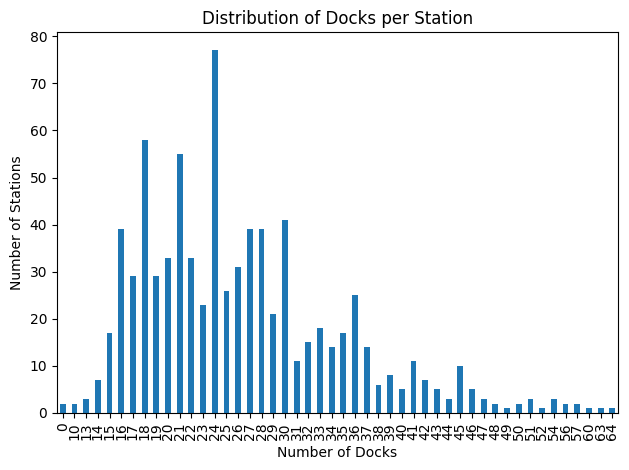

In [30]:
cleaned_stations_df = cycle_stations_df.copy()

# Compute raw counts, sorted by dock‐count value
dist = cleaned_stations_df["docks_count"] \
           .value_counts() \
           .sort_index()

# Turn it into a nice little DataFrame
df_dist = dist.rename_axis("docks_count") \
              .reset_index(name="station_count")

import matplotlib.pyplot as plt

df_dist.plot(x="docks_count", y="station_count", kind="bar", legend=False)
plt.xlabel("Number of Docks")
plt.ylabel("Number of Stations")
plt.title("Distribution of Docks per Station")
plt.tight_layout()
plt.show()



In [31]:
cleaned_stations_df = cycle_stations_df.copy()

# Compute the median docks count for stations with > 0 docks
median_docks = cleaned_stations_df.loc[
    cleaned_stations_df["docks_count"] > 0, 
    "docks_count"
].median()

# Impute docks_count ≤ 0 with the rounded median
cleaned_stations_df.loc[
    cleaned_stations_df["docks_count"] <= 0, 
    "docks_count"
] = int(round(median_docks))


In [32]:
valid_trip_df.to_parquet("storage/Silver/cleaned_cycle_hire.parquet", index=False)
cleaned_stations_df.to_parquet("storage/Silver/cleaned_cycle_stations.parquet", index=False)
